In [1]:
import os, sys, re
import pprint as p
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib widget
%matplotlib inline

py_file_path = os.path.join(
    os.getcwd(),
    "..",
    ".."
)
sys.path.append(py_file_path)
from app.SparkTools import MyPySpark

MySpark = None

#ensure only one sc and spark instance is running
global MySpark
MySpark = MySpark or MyPySpark(
    master = 'local[3]', 
    logger_name = 'jupyter') #jupyter-silent to suppress output

In [2]:
total_energy_df = MySpark\
    .spark\
    .read\
    .parquet("/Processed/TotalEnergyDF")\
    .select("name", "date", "units", "value")\
    .toPandas()

In [123]:
def get_categories(
    in_df, 
    category_rgx,
    unit_rgx,
    filter_column_name = "name", 
    filter_column_units = "units",
    numeric_column = "value"):
    metrics_s = {
        (i, j) for i,j in zip(in_df[filter_column_name], in_df[filter_column_units]) 
        if 
            (match:=re.search(category_rgx, i, re.IGNORECASE))
            and (match:=re.search(unit_rgx, j, re.IGNORECASE)) 
    }

    df = in_df.loc[
        (
            in_df[filter_column_name].isin(
                [i for i, j in metrics_s])
        )].copy()

    df[numeric_column] = df[[numeric_column,]].apply(pd.to_numeric, errors='coerce', axis=1)
    df = df\
        .replace({
            "NA":np.nan
        }).astype(
        {
            numeric_column:"float64",
            "date":"datetime64[ns]"
        }
    )
    df = df.loc[(~(pd.isna(df[numeric_column])))].copy()
    plot_d = {
        'df': df,
        'groups' : [re.match(r'^[^,]+', i).group(0) for i in df["name"]],
        'data_col' : numeric_column,
        'metrics_s' : metrics_s
    }
    
    return  plot_d

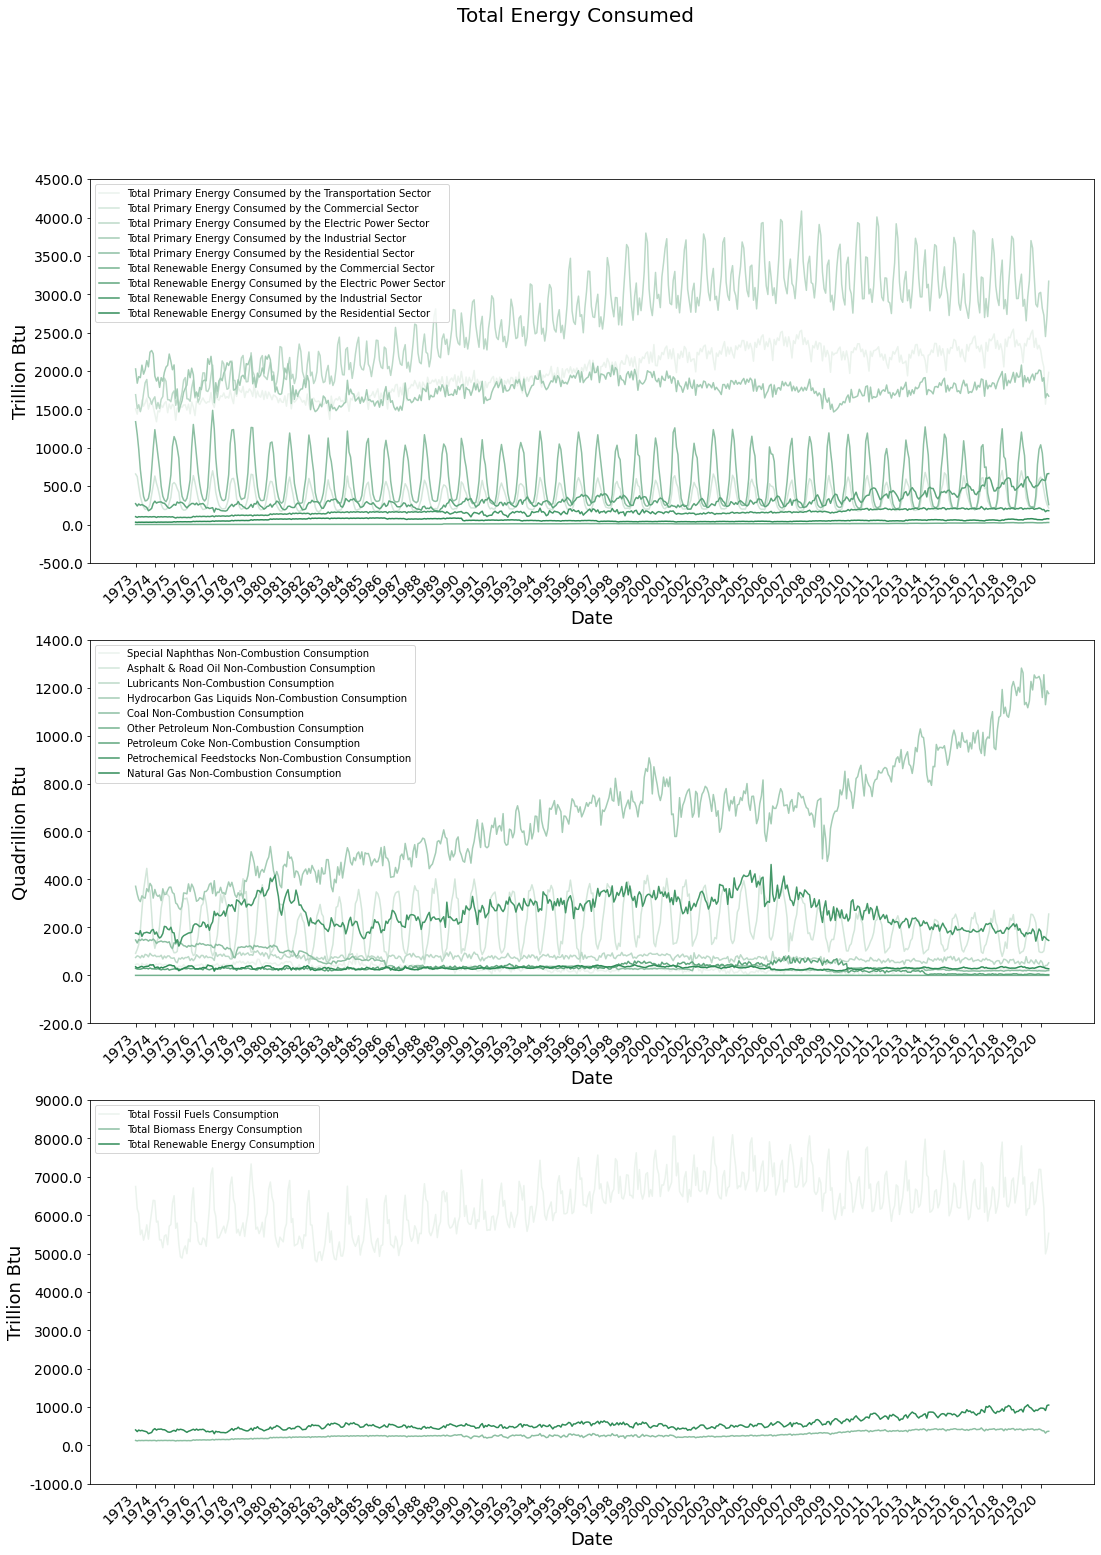

In [129]:
#individual consumption "^(?=Total)(?!Total Primary).*(?=Consumption$)"
#total consumption "^(?!Total).*(?=Consumption$)"
plot_input_l = []
for c_rgx, u_rgx in (
    ["Total (Primary|Renewable) Energy Consumed by the", "Btu"],
    ["^(?!Total).*(?=Consumption$)", "Quadrillion Btu"],
    ["^(?=Total)(?!Total Primary).*(?=Consumption$)", "Trillion Btu"]):    
    plot_d = get_categories(
        in_df = total_energy_df, 
        category_rgx = c_rgx,
        unit_rgx = u_rgx)
    plot_d['date_col'] = 'date'
    plot_d['date_fmt'] = "%Y"
    plot_d['palette'] = sns.light_palette(
            "seagreen", 
            n_colors=len(set(plot_d['groups'])))
    plot_input_l.append(plot_d)
    
font_scale = 1


fig, axs = plt.subplots(len(plot_input_l), 1, figsize=(18,24))

for ax, p_d in zip(axs, plot_input_l):
    ax = sns.lineplot(
        data = p_d["df"],
        x = p_d["df"][p_d["date_col"]],
        y = p_d["df"][p_d["data_col"]],
        hue = p_d["groups"],
        ci = None,
        palette = p_d["palette"],
        ax = ax
    )
    ax.set_xlabel(
        "Date", 
        fontsize = 18 * font_scale)
    ax.set_ylabel(
        ", ".join(list({j for i, j in p_d['metrics_s']})),
        fontsize = 18 * font_scale)
    ax.set_xticks(p_d['df'][p_d["date_col"]].dt.strftime(p_d["date_fmt"]).sort_values().unique().tolist())
    ax.set_xticklabels(
        labels=p_d['df'][p_d["date_col"]].dt.strftime(p_d["date_fmt"]).sort_values().unique().tolist(),
        rotation=45, 
        ha='right',
        fontsize = 14 * font_scale)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(
        labels = ax.get_yticks(),
        fontsize = 14 * font_scale)


fig.suptitle("Total Energy Consumed", fontsize = 20 * font_scale);

